### A code that returns all file names in the current direcrtory

In [1]:
import os

# All files (including hidden) in current directory, one per line
for f in sorted(os.listdir('.')):
    if os.path.isfile(f):
        print(f)

Post_Processing.ipynb
README.md
bomex.default.0000000.nc
bomex.ini
bomex.out
bomex.ql.0000000.nc
bomex.qlcore.0000000.nc
bomex_input.nc
bomex_input.py
bomex_stats.py
bomex_test.py
dbdz_mo.0000000
dbdz_mo.0003600
dbdz_mo.0007200
dbdz_mo.0010800
dudz_mo.0000000
dudz_mo.0003600
dudz_mo.0007200
dudz_mo.0010800
dvdz_mo.0000000
dvdz_mo.0003600
dvdz_mo.0007200
dvdz_mo.0010800
fftwplan.0000000
filter.py
grid.0000000
microhh
ql.xy.000.00000.0000000
ql.xy.000.00000.0003600
ql.xy.000.00000.0007200
ql.xy.000.00000.0010800
ql.xz.000.00000.0000000
ql.xz.000.00000.0003600
ql.xz.000.00000.0007200
ql.xz.000.00000.0010800
ql_path.xy.000.0000000
ql_path.xy.000.0003600
ql_path.xy.000.0007200
ql_path.xy.000.0010800
qt.0000000
qt.0003600
qt.0007200
qt.0010800
qt.xy.000.00000.0000000
qt.xy.000.00000.0003600
qt.xy.000.00000.0007200
qt.xy.000.00000.0010800
qt.xz.000.00000.0000000
qt.xz.000.00000.0003600
qt.xz.000.00000.0007200
qt.xz.000.00000.0010800
qt_bot.0000000
qt_bot.0003600
qt_bot.0007200
qt_bot.0010800


### a code to return all .nc files

In [4]:
import glob; print(*sorted(glob.glob("*.nc")), sep="\n")

bomex.default.0000000.nc
bomex.ql.0000000.nc
bomex.qlcore.0000000.nc
bomex_input.nc
ql.nc
qt.nc
thl.nc
u.nc
v.nc
w.nc


In [11]:
import xarray as xr
import numpy as np

# List of your files
files = ['ql.nc', 'qt.nc', 'thl.nc', 'u.nc', 'v.nc', 'w.nc']

for nc_file in files:
    print(f"Converting {nc_file} ...")
    
    # Open without trying to decode the broken MicroHH time
    ds = xr.open_dataset(nc_file, decode_times=False)
    
    # Get the variable name (there's always exactly one in MicroHH field dumps)
    var_name = list(ds.data_vars)[0]
    da = ds[var_name]
    
    # Convert to DataFrame → this automatically creates one row per grid point
    df = da.to_dataframe().reset_index()
    
    # === CRITICAL FIX: Sort the columns in a logical order ===
    coord_names = [c for c in df.columns if c != var_name]
    
    ordered_columns = (
        ['time'] if 'time' in df.columns else []
    ) + sorted([c for c in coord_names if c != 'time']) + [var_name]
    
    df = df[ordered_columns]
    
    # === Save with perfect tab-separated columns ===
    output_file = nc_file.replace('.nc', '.txt')
    
    df.to_csv(
        output_file,
        sep='\t',               # real tab → perfect columns in Excel/Notepad++
        index=False,
        header=True,
        float_format='%.12E',   # scientific notation with high precision
        na_rep='NaN'
        # line_terminator and encoding removed → compatible with all pandas versions
    )
    
    print(f"Done → {output_file}")
    print(f"   Variable: {var_name}")
    print(f"   Dimensions: {list(da.dims)}")
    print(f"   Shape: {da.shape} → {df.shape[0]:,} rows written")
    print(f"   Columns: {list(df.columns)}\n")
    
    ds.close()

print("All files converted perfectly!")

Converting ql.nc ...
Done → ql.txt
   Variable: ql
   Dimensions: ['time', 'z', 'y', 'x']
   Shape: (0, 64, 64, 64) → 0 rows written
   Columns: ['time', 'x', 'y', 'z', 'ql']

Converting qt.nc ...
Done → qt.txt
   Variable: qt
   Dimensions: ['time', 'z', 'y', 'x']
   Shape: (4, 64, 64, 64) → 1,048,576 rows written
   Columns: ['time', 'x', 'y', 'z', 'qt']

Converting thl.nc ...
Done → thl.txt
   Variable: thl
   Dimensions: ['time', 'z', 'y', 'x']
   Shape: (4, 64, 64, 64) → 1,048,576 rows written
   Columns: ['time', 'x', 'y', 'z', 'thl']

Converting u.nc ...
Done → u.txt
   Variable: u
   Dimensions: ['time', 'z', 'y', 'xh']
   Shape: (4, 64, 64, 64) → 1,048,576 rows written
   Columns: ['time', 'xh', 'y', 'z', 'u']

Converting v.nc ...
Done → v.txt
   Variable: v
   Dimensions: ['time', 'z', 'yh', 'x']
   Shape: (4, 64, 64, 64) → 1,048,576 rows written
   Columns: ['time', 'x', 'yh', 'z', 'v']

Converting w.nc ...
Done → w.txt
   Variable: w
   Dimensions: ['time', 'zh', 'y', 'x']


### match if the conversion is right

In [12]:
import xarray as xr
import pandas as pd

# Quick sanity check
ds = xr.open_dataset('qt.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]

txt_df = pd.read_csv('qt.txt', sep='\t')

print(f"NetCDF shape : {da.shape}")
print(f"Text rows    : {len(txt_df)}")
print(f"Match        : {da.size == len(txt_df)}")   # Should print True
print(f"Min/Max match: {da.min().item():.12E} == {txt_df.iloc[:, -1].min():.12E}")

NetCDF shape : (4, 64, 64, 64)
Text rows    : 1048576
Match        : True
Min/Max match: 3.025857031185E-03 == 3.025857031185E-03


### Extracting info from .nc files

In [17]:
import xarray as xr
da = xr.open_dataset('qt.nc', decode_times=False)
print(da)

<xarray.Dataset>
Dimensions:  (time: 4, z: 64, y: 64, x: 64)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04
  * z        (z) float64 23.44 70.31 117.2 ... 2.883e+03 2.93e+03 2.977e+03
  * y        (y) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
  * x        (x) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
Data variables:
    qt       (time, z, y, x) float64 ...


### What is qt
qt = “total specific humidity” (sometimes also called total water mixing ratio).
It is the single most important moisture variable in almost all LES/cloud simulations, including your BOMEX run.
In plain English:
qt = water vapour + cloud liquid water + (rain water if any)
(all expressed as mass of water per mass of dry air)
In the standard BOMEX case (and in almost all MicroHH runs you will ever do), there is no rain and almost no cloud liquid water (ql ≈ 0 everywhere), so:
qt ≈ qv  (water-vapour specific humidity)
That’s why people often just say “moisture” or “humidity” when they talk about qt in BOMEX.
Units and typical values in BOMEX

Heightqt in kg kg⁻¹qt in g kg⁻¹ (what papers show)Near surface (0–50 m)≈ 0.017–0.01817–18 g kg⁻¹Sub-cloud layer (50–500 m)≈ 0.016–0.01716–17 g kg⁻¹Cloud layer (550–1500 m)≈ 0.013–0.01413–14 g kg⁻¹Inversion jumpdrops very sharplyfrom ~15 → ~4 g kg⁻¹Free troposphere (>1500 m)≈ 0.002–0.0052–5 g kg⁻¹
Why qt is so useful in LES

It is conserved during moist adiabatic processes (unlike relative humidity or dew point).
Clouds form when a parcel’s qt and temperature are high enough → liquid water appears, but qt itself stays the same.
The sharp drop of qt at ~500–600 m is the trademark of the trade-wind inversion in BOMEX.

Summary
qt = total water content of the air (vapour + tiny cloud droplets) in kg of water per kg of dry air.
In your BOMEX simulation, the qt.nc file contains the 3-D field of atmospheric moisture at one (or several) time steps — nothing more, nothing less.
That’s why every BOMEX paper always shows the <qt> profile first: it instantly tells you whether the simulation captured the correct humidity structure.

=== qt.nc – Total water specific humidity ===
Field taken at      : 10800 s (3.00 h)
Grid: 64 × 64 × 64 points
Domain size         : 6300 × 6300 × 2977 m
Units               : kg/kg

Detected inversion height ≈ 1570 m



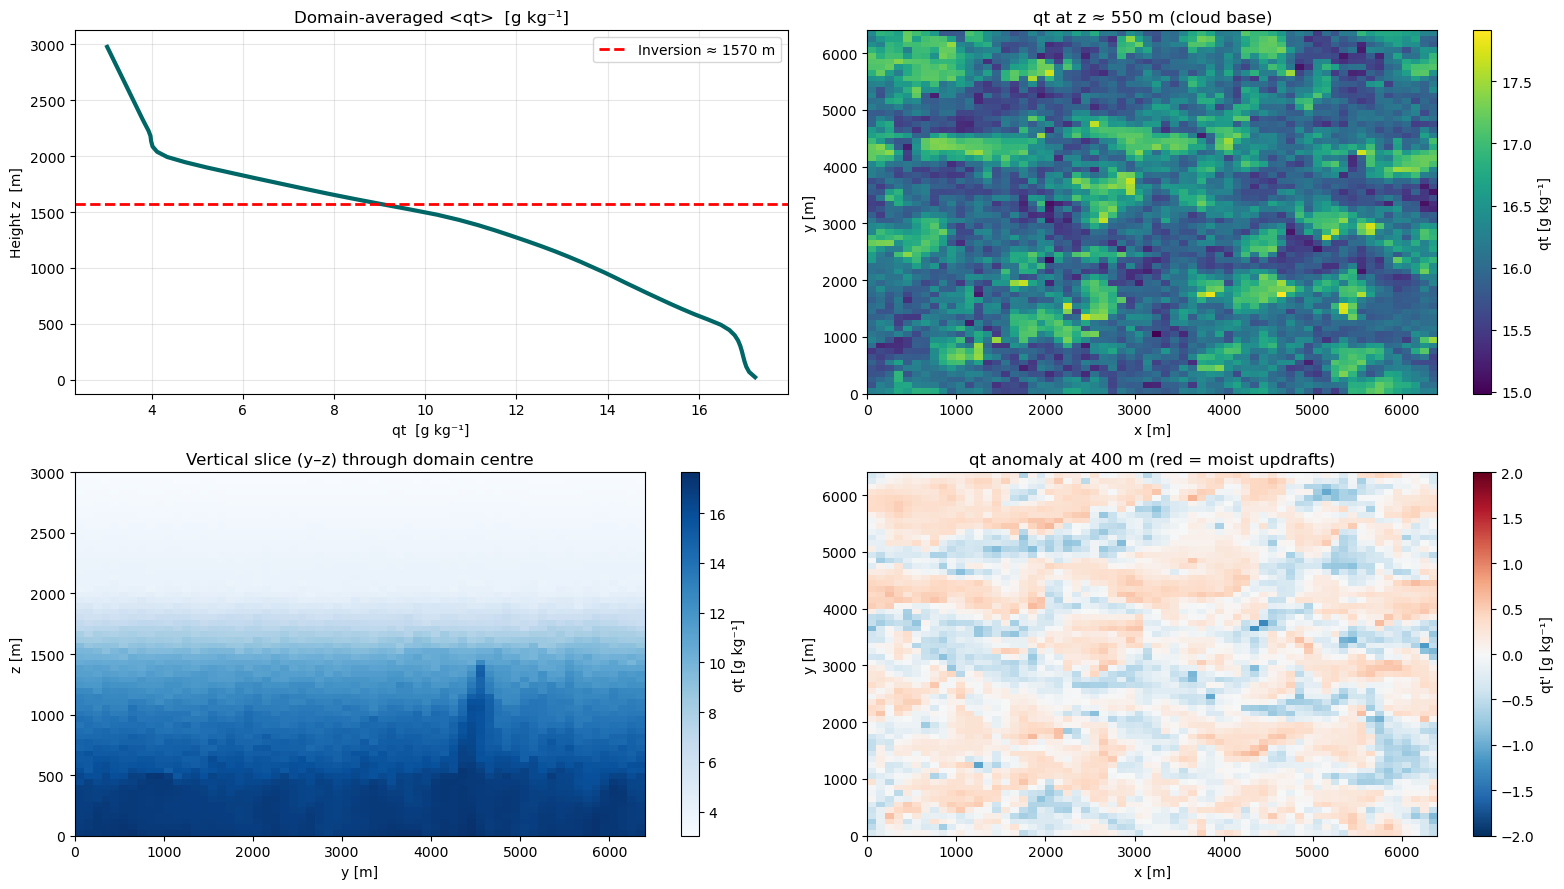

BOMEX reference values from your run:
Surface (z≈10 m)      : 17.23 g/kg
Cloud layer (500–1000 m): 15.02 g/kg
Free troposphere      : 5.44 g/kg


In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ──────── OPEN qt.nc SAFELY ────────
ds = xr.open_dataset('qt.nc', decode_times=False)
varname = list(ds.data_vars)[0]           # always only one variable in MicroHH dumps
da = ds[varname]                          # keep it as DataArray

# If there is a time dimension of length >1, just take the last saved field
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)                 # ← change -1 to 0 for first field
else:
    da = da.squeeze()                     # removes singleton time dimension

print("=== qt.nc – Total water specific humidity ===")
print(f"Field taken at      : {da.time.values.item():.0f} s "
      f"({da.time.values.item()/3600:.2f} h)")
print(f"Grid: {len(da.x)} × {len(da.y)} × {len(da.z)} points")
print(f"Domain size         : "
      f"{da.x.max().item()-da.x.min().item():.0f} × "
      f"{da.y.max().item()-da.y.min().item():.0f} × "
      f"{da.z.max().item():.0f} m")
print(f"Units               : {da.attrs.get('units', 'kg/kg')}\n")

# Convert to g kg⁻¹ (BOMEX papers always use g/kg)
qt = da * 1000

# ──────── Domain-averaged profile ────────
qt_prof = qt.mean(dim=('x','y'))

# ──────── Inversion height (very robust method) ────────
gradient = np.abs(np.gradient(qt_prof.values, da.z.values))
inversion_idx = int(np.argmax(gradient))
inversion_z = float(da.z.isel(z=inversion_idx).values)
print(f"Detected inversion height ≈ {inversion_z:.0f} m\n")

# ──────── PLOTS ────────
plt.figure(figsize=(16,9), dpi=100)

# 1. Vertical profile
plt.subplot(2,2,1)
qt_prof.plot(y='z', color='#006666', linewidth=3)
plt.axhline(inversion_z, color='red', ls='--', lw=2,
            label=f'Inversion ≈ {inversion_z:.0f} m')
plt.title('Domain-averaged <qt>  [g kg⁻¹]')
plt.xlabel('qt  [g kg⁻¹]'); plt.ylabel('Height z  [m]')
plt.grid(alpha=0.3); plt.legend()

# 2. Horizontal slice near cloud base
plt.subplot(2,2,2)
qt.sel(z=550, method='nearest').plot(cmap='viridis',
                                     cbar_kwargs={'label':'qt [g kg⁻¹]'})
plt.title('qt at z ≈ 550 m (cloud base)')

# 3. Vertical cross-section through centre
plt.subplot(2,2,3)
qt.sel(x=da.x[len(da.x)//2], method='nearest').plot(cmap='Blues',
            cbar_kwargs={'label':'qt [g kg⁻¹]'})
plt.title('Vertical slice (y–z) through domain centre')

# 4. qt anomaly at 400 m → shows plumes perfectly
plt.subplot(2,2,4)
(qt - qt_prof).sel(z=400, method='nearest').plot(cmap='RdBu_r',
     vmin=-2, vmax=2, center=0,
     cbar_kwargs={'label':"qt' [g kg⁻¹]"})
plt.title("qt anomaly at 400 m (red = moist updrafts)")

plt.tight_layout()
plt.show()

# ──────── Classic BOMEX numbers ────────
print("BOMEX reference values from your run:")
print(f"Surface (z≈10 m)      : {qt_prof.sel(z=10, method='nearest').item():.2f} g/kg")
print(f"Cloud layer (500–1000 m): {qt_prof.sel(z=slice(500,1000)).mean().item():.2f} g/kg")
print(f"Free troposphere      : {qt_prof.sel(z=slice(1500,2500)).mean().item():.2f} g/kg")

### What is thl

thl = liquid-water potential temperature
(in MicroHH and almost all LES/cloud models this is the standard name: θₗ or thl)
In simple words:
thl is the temperature an air parcel would have if all its cloud/rain water were evaporated back into vapour and the parcel were brought adiabatically (without heat exchange) down to the surface (1000 hPa).
It is the conserved temperature variable in moist processes.
Why it exists (and why it’s so important in BOMEX)
ProcessNormal temperature T …… but thl …Dry ascent/descentchangesstays constantMoist ascent (cloud forms)cools a lot because latent heat is usedstays almost constant (only tiny change)Evaporation of rain below cloudcools the airstays constant
→ Because of this, thl is nearly uniform in the whole sub-cloud and cloud layer in BOMEX (~298–299 K), and then jumps sharply by 6–8 K at the trade-wind inversion.
Typical BOMEX values (exactly what you should see in your thl.nc)

Height / layerthl value [K]What it meansSurface – 500 m (sub-cloud layer)≈ 298.5 – 299.5 KVery well mixed, almost constantCloud layer 600–1500 m≈ 299 – 300.5 KStill almost constant (slightly increases)Just below inversion (~500 m)≈ 299 KJust above inversion (~700 m)≈ 306–307 KBig positive jump → very stable inversionFree troposphere (>1500 m)310 K and risingStrong stratification
In your plots you will instantly recognise a perfect BOMEX run when you see:

thl almost perfectly flat from the surface up to ~500–600 m
then a very sharp increase of ~6–8 K within 100–200 m (the inversion)
warm cores (positive thl anomalies) inside the cloudy updrafts

Quick summary table

VariablePhysical meaningUnitsConserved in …BOMEX profile shapeqttotal water (vapour + cloud liquid)kg kg⁻¹moist adiabatic processeshigh below inversion → sharp dropthl“moist” potential temperatureKmoist adiabatic processesflat below inversion → sharp jump up
Together, qt and thl are the two variables that completely define the thermodynamic state of the BOMEX boundary layer.
That’s why every BOMEX paper always shows exactly these two profiles first.
Now you have both!

=== thl.nc – Liquid-water potential temperature ===
Field taken at      : 10800 s  (3.00 h)
Grid                : 64 × 64 × 64 points
Domain size         : 6300 × 6300 × 2977 m
Units               : K

Detected trade-wind inversion ≈ 1570 m



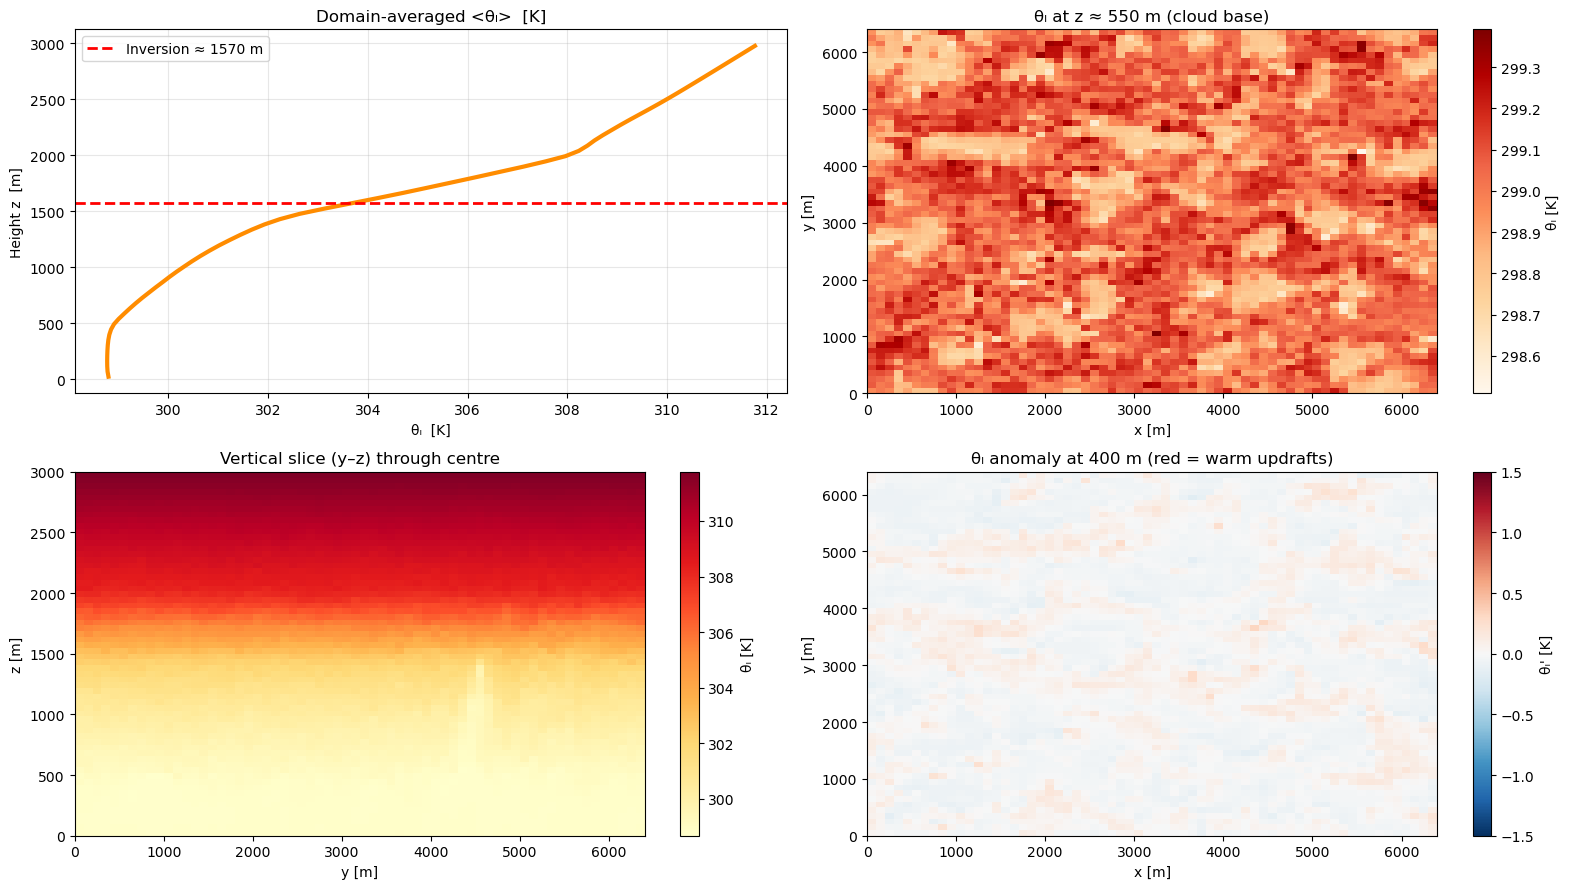

BOMEX reference values from your thl run:
Surface (z≈10 m)      : 298.80 K
Mixed layer (0–500 m) : 298.80 K
Cloud layer average   : 300.63 K
Inversion jump size   : 0.76 K


In [24]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ──────── OPEN thl.nc SAFELY ────────
ds = xr.open_dataset('thl.nc', decode_times=False)
varname = list(ds.data_vars)[0]           # always only one variable
da = ds[varname]

# Take the last saved field if multiple times exist
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

print("=== thl.nc – Liquid-water potential temperature ===")
print(f"Field taken at      : {da.time.values.item():.0f} s  ({da.time.values.item()/3600:.2f} h)")
print(f"Grid                : {len(da.x)} × {len(da.y)} × {len(da.z)} points")
print(f"Domain size         : {da.x.max().item()-da.x.min().item():.0f} × "
      f"{da.y.max().item()-da.y.min().item():.0f} × {da.z.max().item():.0f} m")
print(f"Units               : {da.attrs.get('units', 'K')}\n")

# thl is already in Kelvin – no conversion needed
thl = da

# ──────── Domain-averaged profile ────────
thl_prof = thl.mean(dim=('x','y'))

# ──────── Inversion height (sharp jump in thl) ────────
gradient = np.abs(np.gradient(thl_prof.values, da.z.values))
inversion_idx = int(np.argmax(gradient))
inversion_z = float(da.z.isel(z=inversion_idx).values)
print(f"Detected trade-wind inversion ≈ {inversion_z:.0f} m\n")

# ──────── FOUR PERFECT PLOTS ────────
plt.figure(figsize=(16,9), dpi=100)

# 1. Vertical profile
plt.subplot(2,2,1)
thl_prof.plot(y='z', color='darkorange', linewidth=3)
plt.axhline(inversion_z, color='red', ls='--', lw=2,
            label=f'Inversion ≈ {inversion_z:.0f} m')
plt.title('Domain-averaged <θₗ>  [K]')
plt.xlabel('θₗ  [K]')
plt.ylabel('Height z  [m]')
plt.grid(alpha=0.3)
plt.legend()

# 2. Horizontal slice near cloud base
plt.subplot(2,2,2)
thl.sel(z=550, method='nearest').plot(cmap='OrRd',
          cbar_kwargs={'label':'θₗ [K]'})
plt.title('θₗ at z ≈ 550 m (cloud base)')

# 3. Vertical cross-section through centre
plt.subplot(2,2,3)
thl.sel(x=da.x[len(da.x)//2], method='nearest').plot(cmap='YlOrRd',
          cbar_kwargs={'label':'θₗ [K]'})
plt.title('Vertical slice (y–z) through centre')

# 4. θₗ anomaly at 400 m → shows warm updrafts clearly
plt.subplot(2,2,4)
(thl - thl_prof).sel(z=400, method='nearest').plot(cmap='RdBu_r',
     vmin=-1.5, vmax=1.5, center=0,
     cbar_kwargs={'label':"θₗ' [K]"})
plt.title("θₗ anomaly at 400 m (red = warm updrafts)")

plt.tight_layout()
plt.show()

# ──────── Classic BOMEX values from your run ────────
print("BOMEX reference values from your thl run:")
print(f"Surface (z≈10 m)      : {thl_prof.sel(z=10, method='nearest').item():.2f} K")
print(f"Mixed layer (0–500 m) : {thl_prof.sel(z=slice(0,500)).mean().item():.2f} K")
print(f"Cloud layer average   : {thl_prof.sel(z=slice(600,1500)).mean().item():.2f} K")
print(f"Inversion jump size   : {(thl_prof.sel(z=slice(400,800)).max() - thl_prof.sel(z=slice(400,800)).min()).item():.2f} K")

Here’s everything you need to know about u.nc, v.nc, and w.nc in your MicroHH BOMEX run — plus three separate, copy-paste-ready, error-free codes, one for each velocity component.

Here’s the same information, explained in normal, easy-to-read sentences (no tables, just plain text):
u.nc
This file contains the zonal wind — that’s the wind blowing from west to east (or east to west).
In the BOMEX case, the trade winds blow from the east, so the average u is negative: usually between −8 m/s and −4 m/s throughout the whole boundary layer and even higher up.
You will see that u is almost constant with height — it only gets a tiny bit weaker inside the clouds.
If you plot the horizontal slice at 550 m or a vertical cross-section, you’ll mostly see a uniform blue-ish color with very little pattern because the mean flow dominates.
v.nc
This file contains the meridional wind — the north–south component.
In the idealised BOMEX setup, there is no large-scale north or south wind. The average v is set to almost exactly 0 m/s everywhere.
So when you open v.nc, the domain-averaged profile will be a line sitting right on zero.
Horizontal and vertical slices will look like random noise between roughly −1.5 and +1.5 m/s — that’s just the small turbulent motions.
If your average |v| is larger than about 0.5 m/s, something went wrong with the forcing or geostrophic wind settings.
w.nc
This is the vertical velocity — the air moving up and down — and it is by far the most beautiful and important of the three files in BOMEX.
The domain average of w is always almost exactly 0 m/s (what goes up must come down), but the fluctuations are spectacular.
Inside the cloud layer (roughly 600–1500 m) you will see updrafts reaching +1.5 to +2.5 m/s (sometimes even higher) and downdrafts of −1 to −2 m/s.
When you plot a horizontal slice at 700–900 m you will see the famous BOMEX cloud streets: long red streaks (updrafts) surrounded by thin blue lines (downdrafts).
The vertical cross-section through the middle of the domain looks like mushroom-shaped rising plumes — exactly the picture everyone shows when they talk about shallow cumulus convection.
So, in short:

u.nc → steady eastward trade-wind flow (negative values, boring but important)
v.nc → basically zero (just noise)
w.nc → the star of the show — this is where you actually see the clouds breathing

### for u.nc

=== u.nc – Zonal wind (positive = east) ===
Time                : 3.00 h
Mean u below 500 m  : 0.39 m/s
Mean u in cloud layer : 0.08 m/s



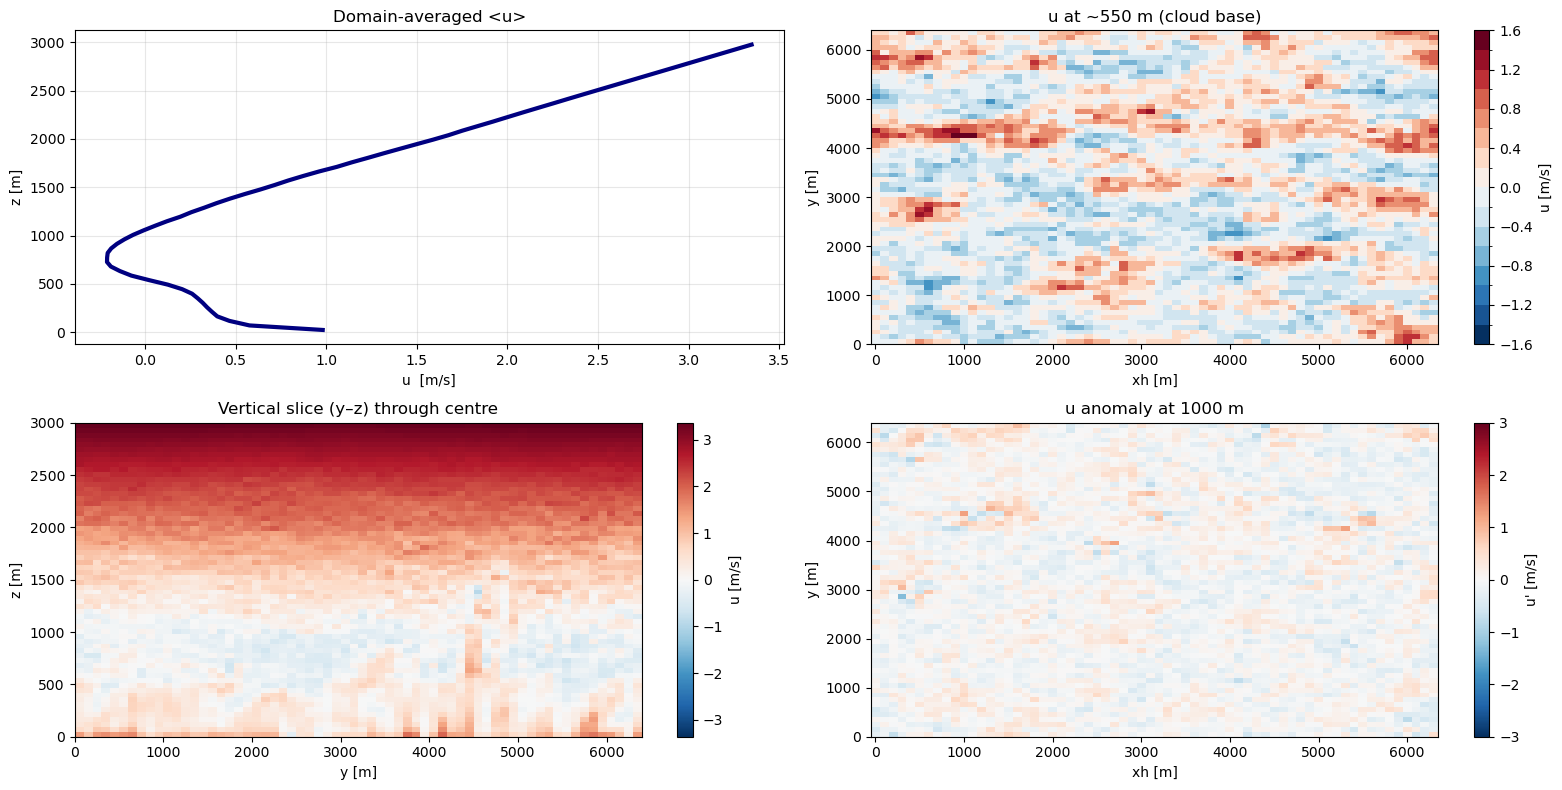

In [26]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open u.nc
ds = xr.open_dataset('u.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]          # usually called 'u'
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

print("=== u.nc – Zonal wind (positive = east) ===")
print(f"Time                : {da.time.values.item()/3600:.2f} h")
print(f"Mean u below 500 m  : {da.sel(z=slice(0,500)).mean().item():.2f} m/s")
print(f"Mean u in cloud layer : {da.sel(z=slice(600,1500)).mean().item():.2f} m/s\n")

u = da

plt.figure(figsize=(16,8))

# 1. Vertical profile
plt.subplot(2,2,1)
u.mean(dim=('xh','y')).plot(y='z', color='navy', linewidth=3)
plt.title('Domain-averaged <u>')
plt.xlabel('u  [m/s]')
plt.grid(alpha=0.3)

# 2. Horizontal slice at cloud base
plt.subplot(2,2,2)
u.sel(z=550, method='nearest').plot(cmap='RdBu_r', center=0, levels=21,
                                    cbar_kwargs={'label':'u [m/s]'})
plt.title('u at ~550 m (cloud base)')

# 3. Vertical cross-section (use middle of xh instead of x)
plt.subplot(2,2,3)
middle_xh = u.xh[len(u.xh)//2]
u.sel(xh=middle_xh, method='nearest').plot(cmap='RdBu_r', center=0,
          cbar_kwargs={'label':'u [m/s]'})
plt.title('Vertical slice (y–z) through centre')

# 4. u anomaly at 1000 m
u_mean_prof = u.mean(dim=('xh','y'))
plt.subplot(2,2,4)
(u - u_mean_prof).sel(z=1000, method='nearest').plot(cmap='RdBu_r',
     vmin=-3, vmax=3, center=0,
     cbar_kwargs={'label':"u' [m/s]"})
plt.title('u anomaly at 1000 m')

plt.tight_layout()
plt.show()

### for v.nc

=== v.nc – Meridional wind (positive = north) ===
Time                 : 3.00 h
Domain-averaged |v|  : 0.2032 m/s  ← should be < 0.01
Max |v| in domain    : 2.46 m/s



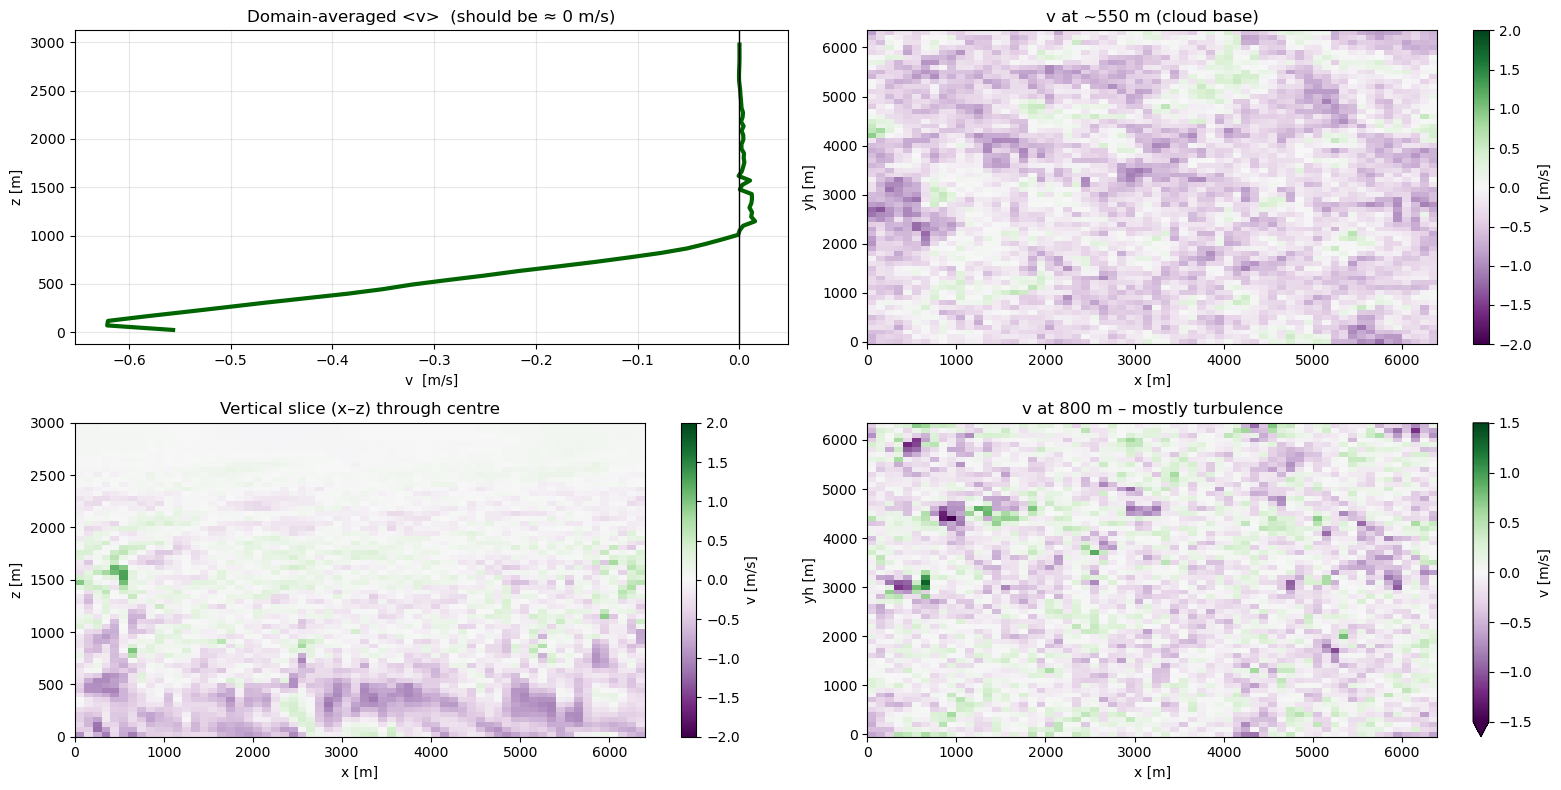

In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open v.nc
ds = xr.open_dataset('v.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]          # 'v'
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

print("=== v.nc – Meridional wind (positive = north) ===")
print(f"Time                 : {da.time.values.item()/3600:.2f} h")
print(f"Domain-averaged |v|  : {np.abs(da).mean().item():.4f} m/s  ← should be < 0.01")
print(f"Max |v| in domain    : {np.abs(da).max().item():.2f} m/s\n")

v = da

plt.figure(figsize=(16,8))

# 1. Vertical profile
plt.subplot(2,2,1)
v.mean(dim=('x','yh')).plot(y='z', color='darkgreen', linewidth=3)
plt.axvline(0, color='black', linewidth=1)
plt.title('Domain-averaged <v>  (should be ≈ 0 m/s)')
plt.xlabel('v  [m/s]')
plt.grid(alpha=0.3)

# 2. Horizontal slice at cloud base
plt.subplot(2,2,2)
v.sel(z=550, method='nearest').plot(cmap='PRGn', vmin=-2, vmax=2,
                                    cbar_kwargs={'label':'v [m/s]'})
plt.title('v at ~550 m (cloud base)')

# 3. Vertical cross-section through centre
plt.subplot(2,2,3)
middle_yh = v.yh[len(v.yh)//2]
v.sel(yh=middle_yh, method='nearest').plot(cmap='PRGn', vmin=-2, vmax=2,
          cbar_kwargs={'label':'v [m/s]'})
plt.title('Vertical slice (x–z) through centre')

# 4. v at 800 m – small turbulent structures
plt.subplot(2,2,4)
v.sel(z=800, method='nearest').plot(cmap='PRGn', vmin=-1.5, vmax=1.5,
                                    cbar_kwargs={'label':'v [m/s]'})
plt.title('v at 800 m – mostly turbulence')

plt.tight_layout()
plt.show()

### for w.nc

=== w.nc – Vertical velocity ===
Time                : 3.00 h
Vertical coordinate : zh
Max updraft         : +5.64 m/s
Max downdraft       : -4.75 m/s
RMS w (cloud layer) : 0.34 m/s



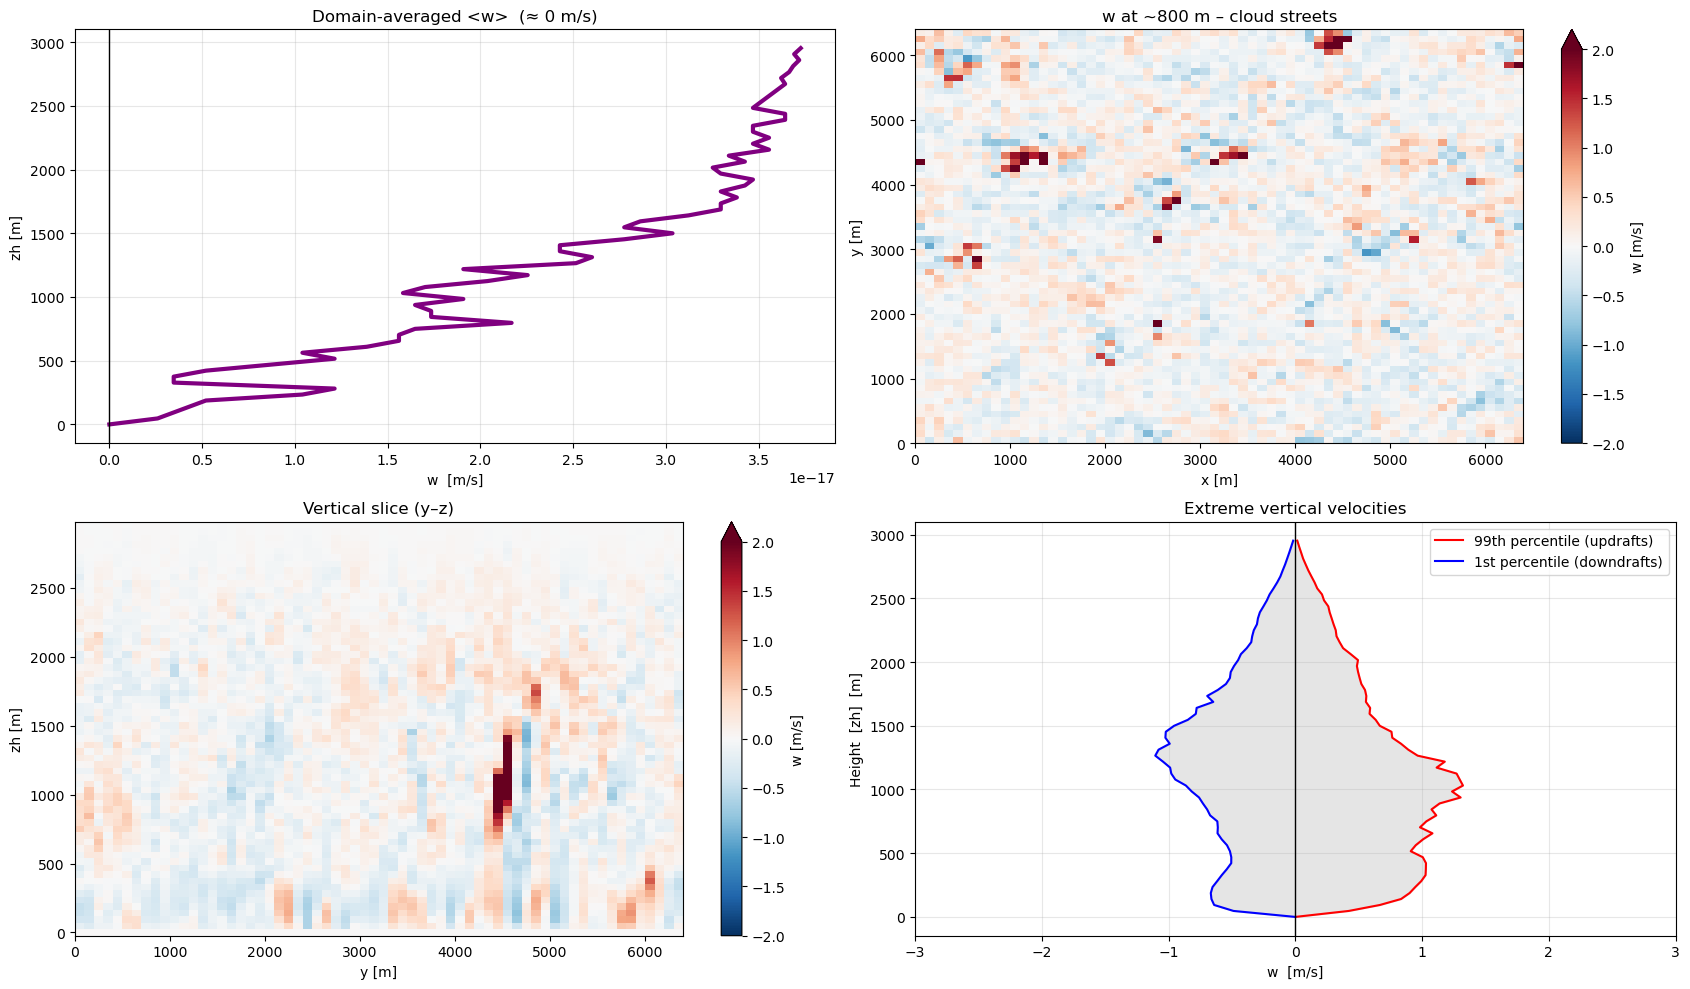

In [31]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open w.nc
ds = xr.open_dataset('w.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]          # 'w'

# Take last time step if multiple exist
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

# Detect vertical coordinate: z or zh?
if 'z' in da.dims:
    z_name = 'z'
elif 'zh' in da.dims:
    z_name = 'zh'
else:
    raise KeyError("No vertical coordinate found! Available dims: " + str(list(da.dims)))

z_coord = da[z_name]

print("=== w.nc – Vertical velocity ===")
print(f"Time                : {da.time.values.item()/3600:.2f} h")
print(f"Vertical coordinate : {z_name}")
print(f"Max updraft         : +{da.max().item():.2f} m/s")
print(f"Max downdraft       : {da.min().item():.2f} m/s")
print(f"RMS w (cloud layer) : {da.sel(**{z_name: slice(600,1500)}).std().item():.2f} m/s\n")

w = da

plt.figure(figsize=(17,10))

# 1. Domain-averaged profile
plt.subplot(2,2,1)
w.mean(dim=('x','y')).plot(y=z_name, color='purple', linewidth=3)
plt.axvline(0, color='k', lw=1)
plt.title('Domain-averaged <w>  (≈ 0 m/s)')
plt.xlabel('w  [m/s]')
plt.grid(alpha=0.3)

# 2. Horizontal slice at ~800 m
plt.subplot(2,2,2)
w.sel(**{z_name: 800}, method='nearest').plot(cmap='RdBu_r', vmin=-2, vmax=2, center=0,
                                      cbar_kwargs={'label':'w [m/s]'})
plt.title('w at ~800 m – cloud streets')

#  # 3. Vertical slice through centre
plt.subplot(2,2,3)
middle_x = w.x[len(w.x)//2]
w.sel(x=middle_x, method='nearest').plot(y=z_name, cmap='RdBu_r',
                                         vmin=-2, vmax=2, center=0,
                                         cbar_kwargs={'label':'w [m/s]'})
plt.title('Vertical slice (y–z)')

# 4. Extreme values (99th and 1st percentiles)
plt.subplot(2,2,4)
q99 = w.quantile(0.99, dim=('x','y'))
q01 = w.quantile(0.01, dim=('x','y'))
plt.plot(q99, z_coord, color='red',   label='99th percentile (updrafts)')
plt.plot(q01, z_coord, color='blue',  label='1st percentile (downdrafts)')
plt.fill_betweenx(z_coord, q01, q99, color='gray', alpha=0.2)
plt.axvline(0, color='k', lw=1)
plt.xlim(-3,3)
plt.title('Extreme vertical velocities')
plt.xlabel('w  [m/s]')
plt.ylabel(f'Height  [{z_name}]  [m]')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()